In [8]:
# If needed:
# !pip install nltk scikit-learn pandas numpy matplotlib

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from matplotlib.lines import Line2D
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jmq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jmq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
DATA_PATH = "events_set1_combined_clean.tsv"
df = pd.read_csv(DATA_PATH, sep="\t")

TEXT_COL  = "tweet_text"
LABEL_COL = "class_label"

df = df.dropna(subset=[TEXT_COL, LABEL_COL])

X = df[TEXT_COL].astype(str).values
y = df[LABEL_COL].astype(str).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(df.columns.tolist())
df.head()



['tweet_id', 'tweet_text', 'class_label', 'place', 'Disaster', 'year', 'split', 'text_clean']


,tweet_id,tweet_text,class_label,place,Disaster,year,split,text_clean
0,798262465234542592,RT @MissEarth: New Zealand need our prayers af...,sympathy_and_support,kaikoura,earthquake,2016,dev,new zealand need our prayers after the devasta...
1,771464543796985856,"@johnaglass65 @gordonluke Ah, woke up to a nig...",caution_and_advice,kaikoura,earthquake,2016,dev,ah woke up to a nightmare 1 earthquake on the ...
2,797835622471733248,RT @terremotocentro: #eqnz if you need a tool ...,requests_or_urgent_needs,kaikoura,earthquake,2016,dev,eqnz if you need a tool for a rapid crowdsourc...
3,798021801540321280,RT @BarristerNZ: My son (4) has drawn a pictur...,other_relevant_information,kaikoura,earthquake,2016,dev,my son 4 has drawn a picture of todays earthqu...
4,798727277794033664,Due to earthquake damage our Defence Force is ...,infrastructure_and_utility_damage,kaikoura,earthquake,2016,dev,due to earthquake damage our defence force is ...


In [4]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

def tokenize_and_stem(text: str):
    text = text.lower()
    # remove URLs and @mentions, keep basic characters
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"[^a-z0-9]+", " ", text)

    tokens = nltk.word_tokenize(text)

    # keep alphabetic tokens, remove stopwords, then stem
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    stems  = [stemmer.stem(t) for t in tokens]
    return stems

In [5]:
tfidf = TfidfVectorizer(
    tokenizer=tokenize_and_stem,
    lowercase=True,
    token_pattern=None,   # important when using a custom tokenizer
    ngram_range=(1, 1),
    max_features=1000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape



(34727, 1000)

In [6]:
clf = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    multi_class="multinomial",
    max_iter=2000,
    C=0.1,
    n_jobs=-1
)

clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))


C:\Users\jmq\anaconda3\envs\torchenv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy : 0.7380787836903939
Macro F1: 0.6021154279671872
                                        precision    recall  f1-score   support

                    caution_and_advice       0.82      0.40      0.54       458
      displaced_people_and_evacuations       0.93      0.86      0.89       427
     infrastructure_and_utility_damage       0.84      0.83      0.83      1209
                injured_or_dead_people       0.88      0.87      0.88       847
               missing_or_found_people       0.75      0.08      0.15        36
                      not_humanitarian       0.67      0.02      0.04       397
            other_relevant_information       0.53      0.70      0.60      1529
              requests_or_urgent_needs       0.68      0.38      0.49       330
rescue_volunteering_or_donation_effort       0.73      0.89      0.80      2433
                  sympathy_and_support       0.88      0.73      0.80      1016

                              accuracy                     

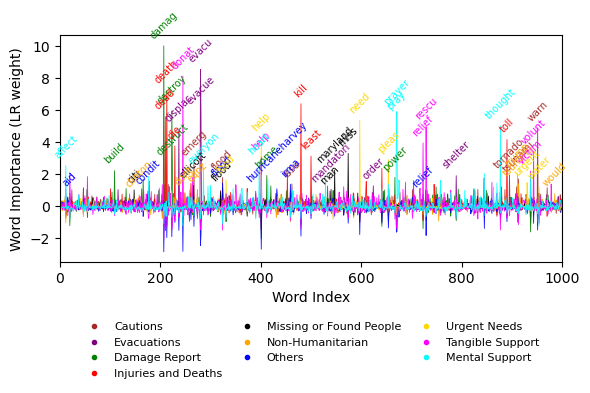

In [9]:
feature_names = np.array(tfidf.get_feature_names_out())
weights = clf.coef_
n_classes, n_features = weights.shape

importance = weights
x = np.arange(n_features)
raw_class_names = list(clf.classes_)

# Map raw labels -> pretty labels (to match Bi-LSTM fig)
pretty_name_map = {
    "caution_and_advice":                     "Cautions",
    "displaced_people_and_evacuations":       "Evacuations",
    "infrastructure_and_utility_damage":      "Damage Report",
    "injured_or_dead_people":                 "Injuries and Deaths",
    "missing_or_found_people":                "Missing or Found People",
    "not_humanitarian":                       "Non-Humanitarian",
    "other_relevant_information":             "Others",
    "requests_or_urgent_needs":               "Urgent Needs",
    "rescue_volunteering_or_donation_effort": "Tangible Support",
    "sympathy_and_support":                   "Mental Support",
}

class_names = raw_class_names  # keep order
pretty_labels = [pretty_name_map.get(c, c.replace("_", " ").title())
                 for c in class_names]

colors = [
    "brown",
    "purple",
    "green",
    "red",
    "black",
    "orange",
    "blue",
    "gold",
    "magenta",
    "cyan"
][:n_classes]

plt.figure(figsize=(6, 4.2))

# plot LR weight lines
for i, name in enumerate(class_names):
    plt.plot(
        x,
        importance[i],
        linewidth=0.6,
        alpha=0.9,
        color=colors[i],
    )

plt.xlabel("Word Index")
plt.ylabel("Word Importance (LR weight)")
plt.xlim(0, 1000)

# annotate top-k tokens
top_k = 6
for i, name in enumerate(class_names):
    idx = np.argsort(importance[i])[::-1][:top_k]
    for j in idx:
        plt.annotate(
            feature_names[j],
            xy=(j, importance[i, j]),
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=7,
            rotation=45,
            ha="center",
            color=colors[i]
        )

# legend with colored dots and pretty labels
dot_handles = []
dot_labels  = []

for i, pretty in enumerate(pretty_labels):
    handle = Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markerfacecolor=colors[i],
        markeredgecolor=colors[i],
        markersize=3   # change this to resize dots
    )
    dot_handles.append(handle)
    dot_labels.append(pretty)

plt.legend(
    handles=dot_handles,
    labels=dot_labels,
    bbox_to_anchor=(0.5, -0.22),
    loc="upper center",
    ncol=3,
    frameon=False,
    fontsize=8,
    columnspacing=1.2
)

plt.tight_layout()
plt.show()
